# Highly-multiplexed image analysis with Harpy

In this notebook we will import an unprocessed spatial proteomics dataset from the MACSima platform and perform some cell segmentation and feature calculation using Harpy.


In [1]:
# To run this notebook with CUDA, install dask-cuda:
#    uv pip install dask-cuda==24.12.0
#
# We pin to this version because spatialdata requires
# dask>=2024.10.0,<=2024.11.2, and dask-cuda 24.12.0
# is the latest release compatible with that range.


from matplotlib import pyplot as plt

import harpy as hp

## 1. Load the example dataset

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`. The dataset is a small subset of a larger dataset that was generated using the MACSima platform.


In [2]:
sdata = hp.datasets.macsima_example()
sdata

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object
└── Images
      └── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images)

Spatial proteomics usually differs from spatial transcriptomics in that the data is mostly highly-multiplexed images instead of just a cell staining and gene transcript locations. In this subsetted example dataset we have an image of 1000 by 1000 pixels and 151 channels from 51 staining rounds. With one DAPI stain per round, there are 100 markers of interest.


In [3]:
marker_names = sdata["HumanLiverH35"].coords["c"].values.tolist()
print(len(marker_names))
", ".join(marker_names)

151


'R0 DAPI, R1 DAPI, R1 VSIG4, R1 CD14, R2 DAPI, R2 CD163, R3 DAPI, R3 CD11c, R3 CD335, R4 DAPI, R4 CD141, R5 DAPI, R5 CD169, R5 CD49d, R6 DAPI, R6 CD279, R7 DAPI, R7 CD4, R7 CD41a, R8 DAPI, R8 CD16b, R9 DAPI, R9 CD26, R9 CD133, R10 DAPI, R10 CD36, R11 DAPI, R11 CD68, R11 CD164, R12 DAPI, R12 CD90, R13 DAPI, R13 Desmin, R13 CD123, R14 DAPI, R14 CD38, R15 DAPI, R15 CD49a, R15 CD1c, R16 DAPI, R16 CD5, R17 DAPI, R17 CD54, R17 CD206, R18 DAPI, R18 CD73, R19 DAPI, R19 CD49b, R19 CD64, R20 DAPI, R20 CD161, R21 DAPI, R21 CD41b, R21 CD55, R22 DAPI, R22 CD56, R23 DAPI, R23 CD105, R23 CD271, R24 DAPI, R24 CD107b, R25 DAPI, R25 CD133, R25 CD13, R26 DAPI, R26 CD11a, R26 CD134, R27 DAPI, R27 CD61, R27 CD177, R27 CD146, R28 DAPI, R28 CD20, R28 CD95, R29 DAPI, R29 CD24, R29 CD196, R29 CD3, R30 DAPI, R30 CD34, R30 CD230, R31 DAPI, R31 CD43, R31 CD243, R31 CD200, R32 DAPI, R32 CD268, R32 CD277, R33 DAPI, R33 CD8, R33 CD28, R33 CD22, R34 DAPI, R34 CD9, R34 CD35, R35 DAPI, R35 CD104, R35 CD235a, R35 CD276,

In [4]:
markers_of_interest = [n for n in marker_names if "DAPI" not in n]
len(markers_of_interest)

100

## 2. Plot the image

We can plot the image to see what it looks like. For this we can use the `harpy.pl.plot_image` function. There is also interoperability with `spatialdata-plot` for advanced visualisation. Note that image intensities are not normalized, so combined plotting of channels may not be very informative.


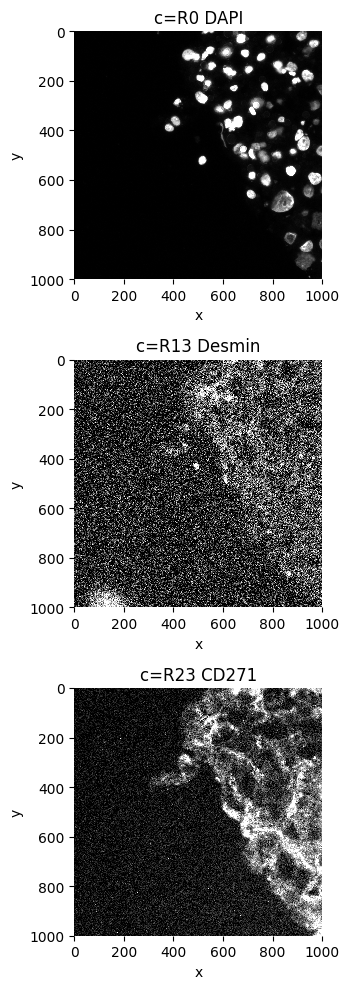

In [5]:
subset_channels = ["R0 DAPI", "R13 Desmin", "R23 CD271"]
hp.pl.plot_image(sdata, img_layer="HumanLiverH35", channel=subset_channels, figsize=(10, 10))

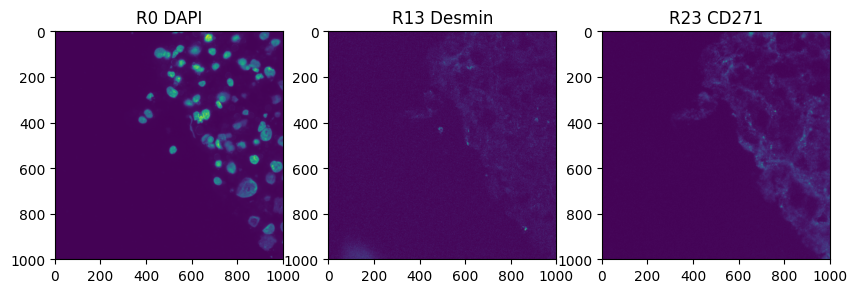

In [6]:
import spatialdata_plot  # noqa

axes = plt.subplots(1, 3, figsize=(10, 10))[1].flatten()
for c, ax in zip(subset_channels, axes, strict=False):
    sdata.pl.render_images("HumanLiverH35", channel=c).pl.show(title=c, ax=ax, colorbar=False)

## 3. Segment using Cellpose


In [7]:
# we first back the spatialdata object to a zarr store:
import os
import tempfile
import uuid

from spatialdata import read_zarr

OUTPUT_DIR = tempfile.gettempdir()

zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata.write(zarr_path, overwrite=True)
sdata = read_zarr(sdata.path)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside                                                                                         
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_a2230775-26ad-469f-bb64-1930d4247cf9.zarr). Please 
         see the documentation of `is_self_contained()` to understand the implications of working with SpatialData 
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_a2230775-26ad-469f-bb64-1930d4247cf9.zarr          


version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [8]:
import torch
from dask.distributed import Client, LocalCluster

from harpy.image import cellpose_callable

img_layer = "HumanLiverH35"

# Get the DAPI stain, and add it to a new slot.
sdata = hp.im.add_image_layer(
    sdata, arr=sdata[img_layer].sel(c="R0 DAPI").data[None, ...], output_layer="image", overwrite=True
)

if torch.cuda.is_available():
    from dask_cuda import LocalCUDACluster  # pip install dask-cuda

    # One worker per GPU; each worker will be pinned to a single GPU.
    cluster = LocalCUDACluster(
        CUDA_VISIBLE_DEVICES=[0],  # or [0,1],...etc
        n_workers=1,  # 2 if [0,1],...etc
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )
else:
    # cpu/mps fall back
    from dask.distributed import LocalCluster

    cluster = LocalCluster(
        n_workers=1
        if torch.backends.mps.is_available()
        else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
        # For this dummy example, we only have one chunk, so setting n_workers>1, has no effect.
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )

client = Client(cluster)

print(client.dashboard_link)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.11.0 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




objc[68785]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x362b51698) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x36cd192f8). One of the two will be used. Which one is undefined.
objc[68785]: Class KeyValueObserver is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x362b516c0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x36cd19320). One of the two will be used. Which one is undefined.
objc[68785]: Class RunLoopModeTracker is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x362b515d0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x36cd19370). One of the two will be used. Which one is undefined.
2025-09-25 10:28:20,258 - harpy.image._manager - INFO - Writing results to 

http://127.0.0.1:65387/status


In [9]:
sdata = hp.im.segment(
    sdata,
    img_layer="image",
    depth=200,
    model=cellpose_callable,
    diameter=50,
    flow_threshold=0.8,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    overwrite=True,
)

client.close()

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.11.0 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




objc[68970]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x31babd698) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x32616d2f8). One of the two will be used. Which one is undefined.
objc[68970]: Class KeyValueObserver is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x31babd6c0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x32616d320). One of the two will be used. Which one is undefined.
objc[68970]: Class RunLoopModeTracker is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x31babd5d0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x32616d370). One of the two will be used. Which one is undefined.
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using defa

## 4. Visualize resulting segmentation


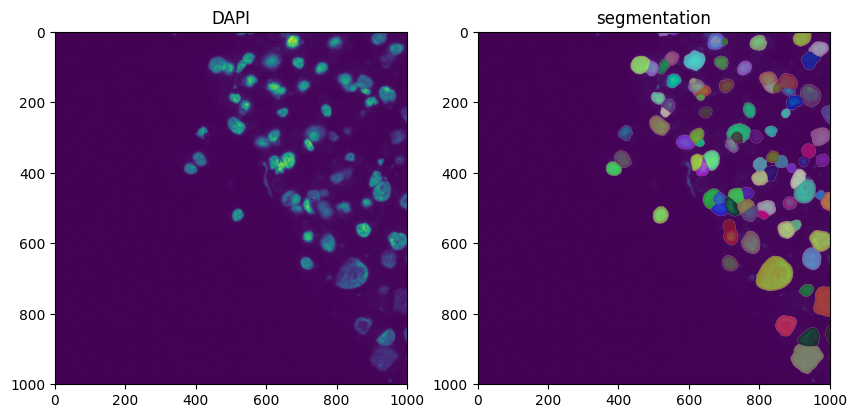

In [10]:
axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("HumanLiverH35", channel="R0 DAPI").pl.show(
    ax=axes[0],
    title="DAPI",
    colorbar=False,
)
sdata.pl.render_images("HumanLiverH35", channel="R0 DAPI").pl.render_labels("segmentation_mask").pl.show(
    title="segmentation",
    ax=axes[1],
    colorbar=False,
)

## 5. Feature extraction

Now we have the location of the cells, we can try to extract features from the image to represent the expression of each cell for the marker. There are many different ways to summarize the signal to a single value. When working on spatial proteomics, it is common to use the mean intensity of the pixels in the cell instead of e.g. the count of transcripts. The mean intensity is a simple and fast way to summarize the signal, but it can be sensitive to noise. A more robust way is to use a quantile normalization first to remove intensity outliers and then calculate the mean intensity. Note that we expect the whole-slide image to be already corrected for illumination and background.

You should inspect the normalized images for each channel, as rare or abundant markers may have different distributions and need different q_min and q_max values, which `harpy.im.normalize` supports.


In [11]:
sdata = hp.im.normalize(
    sdata, img_layer="HumanLiverH35", output_layer="HumanLiverH35_normalized_image", q_min=5, q_max=95
)
sdata

2025-09-25 10:28:35,692 - harpy.image._manager - INFO - Writing results to layer 'HumanLiverH35_normalized_image'
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_a2230775-26ad-469f-bb64-1930d4247cf9.zarr
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     ├── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
│     └── 'image': DataArray[cyx] (1, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (92, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

Calculating the features for every cell is an intensive process and can take a long time. For this small example of 70 cells and 10 channels it can take a couple of seconds. For 51 channels, it can take 30 seconds without additional parallelization. For large whole-slide images, it is recommended to use more cores.


In [12]:
subset = 9  # to speed up the computation, change to None to process all markers
sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    mode="mean",
    channels=["R0 DAPI"] + markers_of_interest[:subset],
)
sdata

/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:286: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[_SPATIAL] = coordinates
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:184: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_a2230775-26ad-469f-bb64-1930d4247cf9.zarr
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     ├── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
│     └── 'image': DataArray[cyx] (1, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Shapes
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (92, 1) (2D shapes)
└── Tables
      └── 'table_intensities': AnnData (92, 10)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

In [13]:
sdata["table_intensities"].to_df()

channels,R0 DAPI,R1 VSIG4,R1 CD14,R2 CD163,R3 CD11c,R3 CD335,R4 CD141,R5 CD169,R5 CD49d,R6 CD279
cells,,,,,,,,,,
38_segmentation_mask_ed15484f,0.971791,0.809246,0.005399,0.071420,0.025679,0.012487,0.031609,0.029887,0.011253,0.029230
39_segmentation_mask_ed15484f,0.959479,0.825022,0.004294,0.059946,0.024327,0.012186,0.034624,0.032157,0.011942,0.026835
41_segmentation_mask_ed15484f,0.939274,0.877863,0.007805,0.081679,0.035323,0.015345,0.035432,0.039999,0.019946,0.031082
42_segmentation_mask_ed15484f,0.998821,0.848713,0.012056,0.074464,0.027920,0.014975,0.035241,0.030530,0.024061,0.031432
44_segmentation_mask_ed15484f,0.971712,0.859654,0.007509,0.068396,0.031179,0.011344,0.032872,0.028308,0.008651,0.031429
...,...,...,...,...,...,...,...,...,...,...
159_segmentation_mask_ed15484f,0.815896,0.969760,0.008407,0.069381,0.033468,0.012814,0.032244,0.047493,0.016810,0.025659
160_segmentation_mask_ed15484f,0.875891,0.959472,0.007579,0.083006,0.036278,0.015100,0.032705,0.067960,0.015616,0.028692
162_segmentation_mask_ed15484f,0.851517,0.954472,0.006897,0.071929,0.036675,0.013482,0.031427,0.041159,0.018839,0.027646


We also can extract geometric and morphological information based on the shape of the cells and append it as extra observations to our table. This can be useful to distinguish between different cell types. For example, we can calculate the area of the cell, the perimeter, the eccentricity, the solidity, the major and minor axis.


In [14]:
sdata = hp.tb.add_regionprop_features(sdata, labels_layer="segmentation_mask", table_layer="table_intensities")
sdata["table_intensities"]

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:184: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
2025-09-25 10:28:40,681 - harpy.utils._io - WARNING - layer with name 'table_intensities' already exists. Overwriting...
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:184: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


AnnData object with n_obs × n_vars = 92 × 10
    obs: 'cell_ID', 'fov_labels', 'area', 'eccentricity', 'major_axis_length', 'minor_axis_length', 'perimeter', 'centroid-0', 'centroid-1', 'convex_area', 'equivalent_diameter', '_major_minor_axis_ratio', '_perim_square_over_area', '_major_axis_equiv_diam_ratio', '_convex_hull_resid', '_centroid_dif'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [15]:
sdata["table_intensities"].obs

,cell_ID,fov_labels,area,eccentricity,major_axis_length,minor_axis_length,perimeter,centroid-0,centroid-1,convex_area,equivalent_diameter,_major_minor_axis_ratio,_perim_square_over_area,_major_axis_equiv_diam_ratio,_convex_hull_resid,_centroid_dif
cells,,,,,,,,,,,,,,,,
38_segmentation_mask_ed15484f,38,segmentation_mask,418.0,0.911566,36.672296,15.077920,87.798990,6.114833,527.631579,438.0,23.069767,2.432185,18.441777,1.589626,0.045662,0.010113
39_segmentation_mask_ed15484f,39,segmentation_mask,224.0,0.854401,23.935207,12.437074,60.177670,4.754464,556.080357,231.0,16.888033,1.924505,16.166750,1.417288,0.030303,0.004816
41_segmentation_mask_ed15484f,41,segmentation_mask,1832.0,0.625884,54.902127,42.819061,161.053824,19.825328,918.089520,1862.0,48.296737,1.282189,14.158479,1.136767,0.016112,0.002700
42_segmentation_mask_ed15484f,42,segmentation_mask,1630.0,0.518932,49.679603,42.466898,158.539105,29.828834,672.452761,1754.0,45.556344,1.169843,15.420029,1.090509,0.070696,0.020818
44_segmentation_mask_ed15484f,44,segmentation_mask,1679.0,0.434846,48.848925,43.988686,153.539105,33.885051,794.118523,1732.0,46.236016,1.110488,14.040653,1.056512,0.030600,0.003937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159_segmentation_mask_ed15484f,159,segmentation_mask,3575.0,0.819419,91.058122,52.194041,245.982756,765.969790,977.608112,3691.0,67.467261,1.744608,16.925179,1.349664,0.031428,0.007678
160_segmentation_mask_ed15484f,160,segmentation_mask,2629.0,0.414142,61.069828,55.586500,194.166522,833.037657,871.918600,2697.0,57.856259,1.098645,14.340296,1.055544,0.025213,0.002329
162_segmentation_mask_ed15484f,162,segmentation_mask,593.0,0.950318,51.005032,15.876869,116.526912,858.200675,993.239460,606.0,27.477828,3.212537,22.898012,1.856225,0.021452,0.005510


<Axes: >

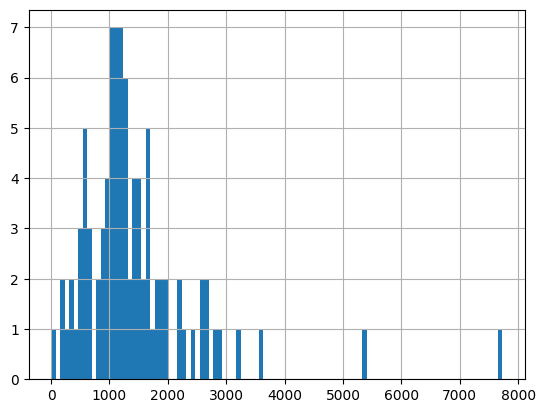

In [16]:
sdata["table_intensities"].obs["area"].hist(bins=100)

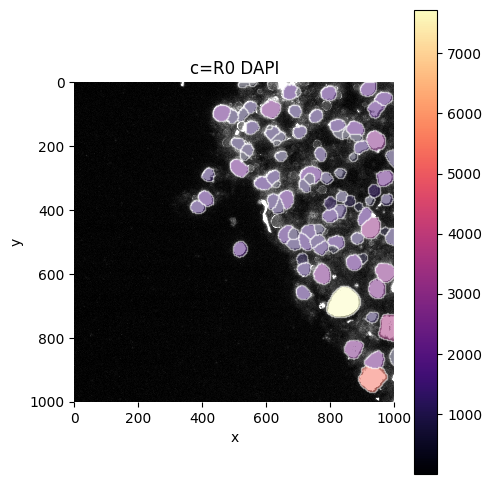

In [17]:
hp.pl.plot_shapes(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    shapes_layer="segmentation_mask_boundaries",
    table_layer="table_intensities",
    column="area",
    channel="R0 DAPI",
    figsize=(5, 5),
)

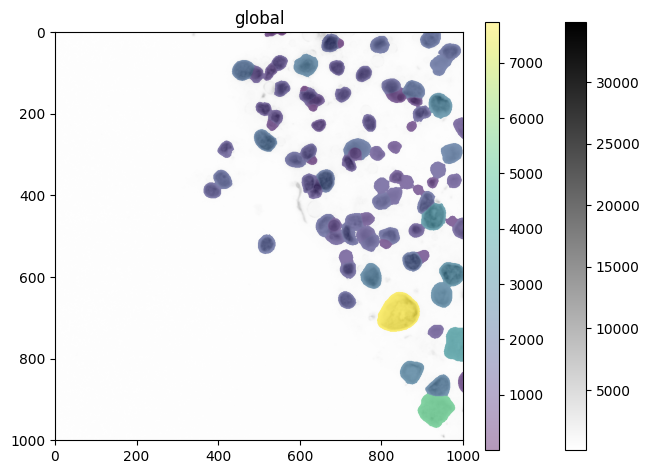

In [18]:
# or using spatialdata-plot
sdata.pl.render_images("HumanLiverH35", channel="R0 DAPI", cmap="binary").pl.render_labels(
    "segmentation_mask", color="area", table_name="table_intensities"
).pl.show()

Guidance on performing pixel and cell clustering using `Harpy` together with [FlowSom](https://github.com/saeyslab/FlowSOM_Python), can be found in [this notebook](./FlowSOM_for_pixel_and_cell_clustering.ipynb).

For a detailed tutorial on extracting features from raster data with `Harpy`, see [this notebook](../advanced/Harpy_aggregate_rasters.ipynb).

For additional information on spatial transcriptomics, we refer to the [SPArrOW documentation](https://sparrow-pipeline.readthedocs.io/en/latest), and [this notebook](../advanced/Harpy_transcriptomics.ipynb).